In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for pipelines and grid search
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

# Dimensionality Reduction algoriths
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import RFE
from sklearn.manifold import LocallyLinearEmbedding

# Regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Performance metrics for model evaluation
from sklearn import metrics

import shap

import datetime

import warnings
warnings.filterwarnings("ignore")

### 1. EDA

In [2]:
# Import the raw data from clinical and cnrq/miRNA samples data files

df_clinical = pd.read_csv("ICORG database for analysis 2021 - clinical - CSV.csv")

df_cnrq = pd.read_csv("ICORG database for analysis 2021 - cnrq - CSV.csv")

df_cnrq.drop('Unnamed: 17', axis=1, inplace=True)

In [3]:
# Take a look at the the two data frames

df_clinical.head()

Patient No.   Age ER Status PR Status HER2 Status Tumour Subtype  \
0          1.0  67.0  Positive  Negative    Negative      Luminal A   
1          2.0  53.0  Positive  Positive    Negative      Luminal A   
2          3.0  65.0  Positive  Positive    Negative      Luminal A   
3          4.0   NaN  Positive  Negative    Positive      Luminal B   
4          5.0   NaN  Positive  Positive    Positive      Luminal B   

  Node Result  Mammogram Size  Tumour Grade Surgical Procedure  \
0    Negative             NaN           2.0                WLE   
1         NaN             4.0           2.0                WLE   
2    Positive             7.0           2.0                WLE   
3    Positive             7.0           2.0         Mastectomy   
4    Negative             NaN           2.0         Mastectomy   

   Invasive Tumour size on histology (cm) Tumour bed response to NACT  \
0                                     3.0                     Partial   
1                                     6.3                     Partial   
2                                     4.0                     Partial   
3                                     3.8                        Good   
4                                     1.4                        Good   

   Number of Nodes Involved Final combined pCR status   NPI  Mammographic NPI  
0                       5.0                        No  5.60               NaN  
1                       3.0                        No  6.26               4.8  
2                      13.0                        No  5.60               6.4  
3                       4.0                        No  5.76               6.4  
4                       0.0                        No  3.28               NaN

In [4]:
df_cnrq.head()

Samples Let-7a CNRQ Let-7a SE(CNRQ) miR-10b CNRQ miR-10b SE(CNRQ)  \
0     1-1    0.619542        0.043492    -0.258232         0.022169   
1     1-2    0.268956        0.031020     0.466741         0.037892   
2     1-3   -0.330399        0.038581    -0.271332         0.038458   
3     1-4    1.202915        0.019768     1.314104         0.016260   
4     1-5    0.668195        0.029424     0.473851         0.031627   

  miR-145 CNRQ miR-145 SE(CNRQ) miR-155 CNRQ miR-155 SE(CNRQ) miR-16 CNRQ  \
0     0.248945         0.032727    -1.948633         0.038655    0.245929   
1     0.688605         0.029129          NaN              NaN    0.249567   
2     0.354952         0.031385     0.057162         0.040371   -0.265812   
3     1.859136         0.038551     1.561874         0.019562    1.117200   
4     0.841119         0.025823    -3.370786         0.045068    0.241619   

  miR-16 SE(CNRQ) miR-195 CNRQ miR-195 SE(CNRQ) miR-21 CNRQ miR-21 SE(CNRQ)  \
0        0.010475     0.756180         0.012659    0.588606        0.013795   
1        0.014383     0.528927         0.020011    0.631142        0.028848   
2        0.021709    -0.283067         0.029393   -0.297470        0.036457   
3        0.010158    -0.496248         0.030897    1.799202        0.025332   
4        0.035241     0.713116         0.020807    0.788514        0.039980   

  miR-425 CNRQ miR-425 SE(CNRQ)  
0    -0.245929         0.014497  
1    -0.249567         0.020417  
2     0.265812         0.027783  
3    -1.117200         0.019028  
4    -0.241619         0.024060

In [5]:
# Create two new features by splitting the "Sample" feature into "Patient No." and "Sample No."
df_cnrq.insert(0,'Patient No.',df_cnrq.Samples.str.split('-').str[0])
df_cnrq.insert(1,'Sample No.',df_cnrq.Samples.str.split('-').str[1])
df_cnrq.drop('Samples', axis=1, inplace=True)

idxs = list(df_cnrq.columns)[0:2]
cols = list(df_cnrq.columns)[2:]

df_cnrq[idxs] = df_cnrq[idxs].apply(pd.to_numeric, errors='coerce', axis=1)
df_cnrq[cols] = df_cnrq[cols].apply(pd.to_numeric, errors='coerce', axis=1)

df_clinical['Patient No.'] = df_clinical['Patient No.'].apply(pd.to_numeric, errors='coerce')

In [6]:
# Each patient has up to 5 sample rows for each miRNA measurement so we need to denormalise before joining

f_cnrq_denorm = pd.DataFrame()

# Denormalisation routine

for x in range(1, 6):
    temp_df = df_cnrq[(df_cnrq['Sample No.'] == x)].copy()
    
    cols = temp_df.columns[2:]
    
    for col in cols:
        new_col = "Sample_" + str(x) + "_" + col
        temp_df.rename(columns = {col:new_col}, inplace = True)

    temp_df.drop('Sample No.', axis=1, inplace=True)
    temp_df.set_index('Patient No.')
    
    if x > 1:
        df_cnrq_denorm = pd.merge(df_cnrq_denorm, temp_df, how='left', on='Patient No.')

    else:
        df_cnrq_denorm = temp_df.copy()   

# Join datasets
df = pd.merge(df_clinical, df_cnrq_denorm, on='Patient No.', how='left')

In [7]:
# Drop rows with all columns data missing values

df = df.dropna(how='all')

In [8]:
# Based on discussion with James, columns with'_miR_10' can be deleted as well as all of Sample 5

del_col_names = ['Sample_1_miR-10b CNRQ', 'Sample_1_miR-10b SE(CNRQ)',
                 'Sample_2_miR-10b CNRQ', 'Sample_2_miR-10b SE(CNRQ)',
                 'Sample_3_miR-10b CNRQ', 'Sample_3_miR-10b SE(CNRQ)',
                 'Sample_4_miR-10b CNRQ', 'Sample_4_miR-10b SE(CNRQ)',
                 'Sample_5_miR-10b CNRQ', 'Sample_5_miR-10b SE(CNRQ)'
                ]
df = df.drop(del_col_names, axis=1)

# Drop columns from Sample 5

df = df.drop(df.filter(regex='Sample_5').columns, axis=1)

df = df.drop(df.filter(regex='Unnamed').columns, axis=1)

In [9]:
# Reset all 'missing' values with standard NaN

df = df.replace('Missing', np.NaN)

In [10]:
# Drop Mammographic NPI, for now, as it has a large amount of missing data
# Patient No. is not needed for this part of the analysis

drop_cols = ['Mammographic NPI', 'Patient No.']

df = df.drop(drop_cols, axis=1)

In [11]:
df.shape

(124, 70)

In [12]:
# Summary statistics on numeric data

df.describe()

Age  Mammogram Size  Tumour Grade  \
count  102.000000       89.000000    122.000000   
mean    55.088235        4.173034      2.459016   
std     10.599928        2.065670      0.516625   
min     25.000000        0.800000      1.000000   
25%     48.000000        2.800000      2.000000   
50%     55.000000        3.700000      2.000000   
75%     63.000000        5.000000      3.000000   
max     76.000000       10.000000      3.000000   

       Invasive Tumour size on histology (cm)  Number of Nodes Involved  \
count                              116.000000                120.000000   
mean                                 2.423190                  2.916667   
std                                  3.442705                  5.389974   
min                                  0.000000                  0.000000   
25%                                  0.000000                  0.000000   
50%                                  1.350000                  0.000000   
75%                                  3.850000                  3.250000   
max                                 24.000000                 26.000000   

              NPI  Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  \
count  111.000000            112.000000                112.000000   
mean     4.659730             -0.079412                  0.026967   
std      1.208609              0.732854                  0.012864   
min      2.380000             -3.099901                  0.008775   
25%      4.000000             -0.465806                  0.017465   
50%      4.280000              0.007653                  0.024258   
75%      5.310000              0.349460                  0.035144   
max      9.800000              1.606284                  0.101109   

       Sample_1_miR-145 CNRQ  Sample_1_miR-145 SE(CNRQ)  ...  \
count             111.000000                 111.000000  ...   
mean                0.008271                   0.028359  ...   
std                 0.578259                   0.014445  ...   
min                -2.286769                   0.003589  ...   
25%                -0.336913                   0.017690  ...   
50%                 0.142475                   0.026165  ...   
75%                 0.386108                   0.035616  ...   
max                 1.287875                   0.103618  ...   

       Sample_4_miR-155 CNRQ  Sample_4_miR-155 SE(CNRQ)  Sample_4_miR-16 CNRQ  \
count              99.000000                  99.000000            104.000000   
mean                0.109081                   0.025659             -0.030381   
std                 0.481065                   0.010209              0.311288   
min                -2.169371                   0.006872             -0.882712   
25%                -0.142441                   0.019311             -0.214911   
50%                 0.064396                   0.023149              0.000778   
75%                 0.386088                   0.031429              0.162914   
max                 1.561874                   0.059134              1.117200   

       Sample_4_miR-16 SE(CNRQ)  Sample_4_miR-195 CNRQ  \
count                104.000000             103.000000   
mean                   0.020929              -0.033178   
std                    0.011126               0.542417   
min                    0.002648              -2.294798   
25%                    0.012043              -0.260383   
50%                    0.018916               0.001724   
75%                    0.025542               0.222892   
max                    0.052680               1.521760   

       Sample_4_miR-195 SE(CNRQ)  Sample_4_miR-21 CNRQ  \
count                 103.000000            101.000000   
mean                    0.026193              0.089953   
std                     0.022747              0.719077   
min                     0.008327             -2.251557   
25%                     0.017202             -0.168710   
50%                     0.022226              0.183669   
75%                 

In [13]:
# Calculate the percentage of missing data for each feature

pd.set_option("display.max_rows", None, "display.max_columns", None)
df.isna().sum()/df.shape[0]*100

Age                                       17.741935
ER Status                                  0.000000
PR Status                                  0.000000
HER2 Status                                0.000000
Tumour Subtype                             0.000000
Node Result                               27.419355
Mammogram Size                            28.225806
Tumour Grade                               1.612903
Surgical Procedure                         1.612903
Invasive Tumour size on histology (cm)     6.451613
Tumour bed response to NACT                3.225806
Number of Nodes Involved                   3.225806
Final combined pCR status                  3.225806
NPI                                       10.483871
Sample_1_Let-7a CNRQ                       9.677419
Sample_1_Let-7a SE(CNRQ)                   9.677419
Sample_1_miR-145 CNRQ                     10.483871
Sample_1_miR-145 SE(CNRQ)                 10.483871
Sample_1_miR-155 CNRQ                      8.870968
Sample_1_miR

In [14]:
# Calculate skewness of distribution

from scipy.stats import skew

skew_df = pd.DataFrame(columns=['Feature', 'Skewness'])

cols = df.select_dtypes(include='number').columns

for col in cols:
    skew_val = np.round(skew(df[col], nan_policy='omit'), 4)
    new_row = {'Feature': col, 'Skewness': skew_val}
    skew_df = skew_df.append(new_row, ignore_index=True)

skew_df

Feature  Skewness
0                                      Age   -0.1131
1                           Mammogram Size    0.7988
2                             Tumour Grade   -0.0163
3   Invasive Tumour size on histology (cm)    2.9432
4                 Number of Nodes Involved    2.4523
5                                      NPI    1.0525
6                     Sample_1_Let-7a CNRQ   -0.8908
7                 Sample_1_Let-7a SE(CNRQ)    1.9288
8                    Sample_1_miR-145 CNRQ   -0.9191
9                Sample_1_miR-145 SE(CNRQ)    1.5302
10                   Sample_1_miR-155 CNRQ   -2.0294
11               Sample_1_miR-155 SE(CNRQ)    1.7716
12                    Sample_1_miR-16 CNRQ   -0.0428
13                Sample_1_miR-16 SE(CNRQ)    2.4235
14                   Sample_1_miR-195 CNRQ   -1.2906
15               Sample_1_miR-195 SE(CNRQ)    2.6217
16                    Sample_1_miR-21 CNRQ   -2.0074
17                Sample_1_miR-21 SE(CNRQ)    1.8817
18                   Sample_1_miR-425 CNRQ    0.0428
19               Sample_1_miR-425 SE(CNRQ)    6.9500
20                    Sample_2_Let-7a CNRQ   -0.2381
21                Sample_2_Let-7a SE(CNRQ)    0.4741
22                   Sample_2_miR-145 CNRQ   -0.3903
23               Sample_2_miR-145 SE(CNRQ)    0.3099
24                   Sample_2_miR-155 CNRQ   -0.4426
25               Sample_2_miR-155 SE(CNRQ)    0.3946
26                    Sample_2_miR-16 CNRQ   -0.4162
27                Sample_2_miR-16 SE(CNRQ)    1.0687
28                   Sample_2_miR-195 CNRQ   -2.1577
29               Sample_2_miR-195 SE(CNRQ)    0.4038
30                    Sample_2_miR-21 CNRQ   -1.2060
31                Sample_2_miR-21 SE(CNRQ)    0.9121
32                   Sample_2_miR-425 CNRQ    0.4162
33               Sample_2_miR-425 SE(CNRQ)    2.4450
34                    Sample_3_Let-7a CNRQ   -0.8865
35                Sample_3_Let-7a SE(CNRQ)    0.6064
36                   Sample_3_miR-145 CNRQ    0.3395
37               Sample_3_miR-145 SE(CNRQ)    0.9391
38                   Sample_3_miR-155 CNRQ   -1.1272
39               Sample_3_miR-155 SE(CNRQ)    0.3588
40                    Sample_3_miR-16 CNRQ   -0.0064
41                Sample_3_miR-16 SE(CNRQ)    0.8069
42                   Sample_3_miR-195 CNRQ   -1.3693
43               Sample_3_miR-195 SE(CNRQ)    0.9511
44                    Sample_3_miR-21 CNRQ   -0.7334
45                Sample_3_miR-21 SE(CNRQ)    0.9786
46                   Sample_3_miR-425 CNRQ    0.0064
47               Sample_3_miR-425 SE(CNRQ)    0.8625
48                    Sample_4_Let-7a CNRQ   -0.4240
49                Sample_4_Let-7a SE(CNRQ)    0.6311
50                   Sample_4_miR-145 CNRQ    0.3687
51               Sample_4_miR-145 SE(CNRQ)    9.0697
52                   Sample_4_miR-155 CNRQ   -0.5581
53               Sample_4_miR-155 SE(CNRQ)    0.7610
54                    Sample_4_miR-16 CNRQ    0.0361
55                Sample_4_miR-16 SE(CNRQ)    0.8654
56                   Sample_4_miR-195 CNRQ   -1.1400
57               Sample_4_miR-195 SE(CNRQ)    7.4059
58                    Sample_4_miR-21 CNRQ   -0.8806
59                Sample_4_miR-21 SE(CNRQ)    0.8742
60                   Sample_4_miR-425 CNRQ   -0.0361
61               Sample_4_miR-425 SE(CNRQ)    0.7628

#### Determining Mean or Median imputer for Skewed Data
From: https://www.pluralsight.com/guides/interpreting-data-using-descriptive-statistics-python

- Highly skewed distribution: If the skewness value is less than −1 or greater than +1.

- Moderately skewed distribution: If the skewness value is between −1 and −½ or between +½ and +1.

- Approximately symmetric distribution: If the skewness value is between −½ and +½.

Therefore, for _Skewness_ values between -0.5 and + 0.5 we use *mean* otherwise use *median*.

This is also very useful in determining whether to use MinMaxScaler or StandardScaler.

MinmaxScaler is negatively impacted by large skewness, i.e. outliers, while StandardScaler is not.

We can use StandardScaler followed by MinMax.

In [15]:
# Display the distribution of categorical features to determine class imbalance

all_cols = df.columns

cat_cols = list(set(all_cols) - set(cols))

for cat in cat_cols:
    cnt = df[cat].count()
    num_elem = (df.groupby([cat])[cat].count())/cnt*100
    print (num_elem, '\n')

HER2 Status
Negative    69.354839
Positive    30.645161
Name: HER2 Status, dtype: float64 

Node Result
Negative    14.444444
Positive    85.555556
Name: Node Result, dtype: float64 

Tumour bed response to NACT
Complete    32.500000
Good        14.166667
Partial     45.000000
Poor         8.333333
Name: Tumour bed response to NACT, dtype: float64 

Final combined pCR status
No     73.333333
Yes    26.666667
Name: Final combined pCR status, dtype: float64 

PR Status
Negative    46.774194
Positive    53.225806
Name: PR Status, dtype: float64 

ER Status
Negative    34.677419
Positive    65.322581
Name: ER Status, dtype: float64 

Tumour Subtype
Her2               12.903226
Luminal A          49.193548
Luminal B          17.741935
Triple Negative    20.161290
Name: Tumour Subtype, dtype: float64 

Surgical Procedure
Mastectomy    44.262295
WLE           55.737705
Name: Surgical Procedure, dtype: float64 



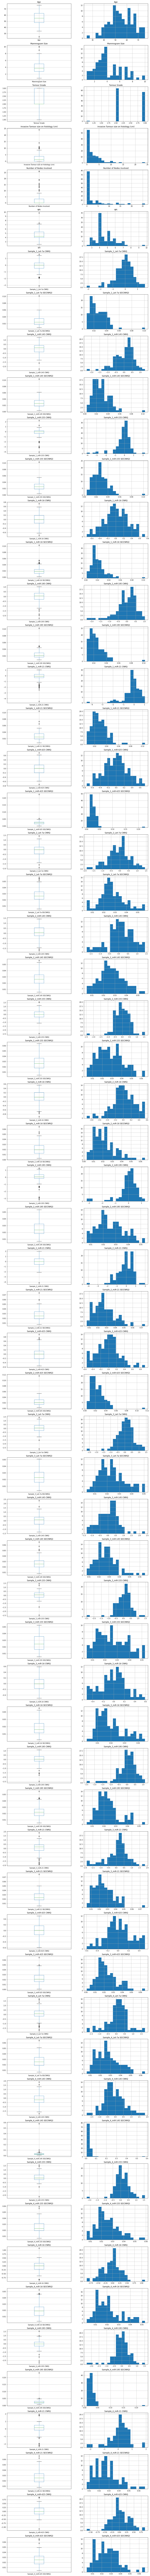

In [16]:
# Plot histograms of number values

fig = plt.figure(figsize=(16,300))
n= 1
num = len(cols)

for col in cols:
    ax1 = fig.add_subplot(num, 2, n)
    ax1.set_title(col)
    df.boxplot(column=col)

    ax2 = fig.add_subplot(num, 2, n+1)
    ax2.set_title(col)
    df[col].hist(bins=20)
    
    n+=2

In [17]:
# Export the df dataset (unprocessed)

df.to_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_No_Processing.csv")

In [18]:
# Spearte the dataset into Training and Test Datasets before doing any analysis or feature engineering
# NOTE: Separating the data depends on whether we will be doing regression or classification.
# Classification needs to be stratified on the target so we get even distributions of classes in train and test.

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42) # No stratify as this will be a regression task
print("Dataset shape: Training", df_train.shape, "Test", df_test.shape)

Dataset shape: Training (99, 70) Test (25, 70)


In [19]:
# Analyse the df_training dataset for skewness and determine which colunmns to apply mean or median

cols_mean = []
cols_median = []

for col in cols:
    skewness = skew(df_train[col], nan_policy='omit')
    if skewness >= -0.5 and skewness <= 0.5:
        cols_mean.append(col)
    else: cols_median.append(col)

if 'NPI' in cols_mean: cols_mean.remove('NPI')
else: cols_median.remove('NPI')

In [20]:
# Calculate mean and median for columns in each list and store for later use with test dataset
# Values stored in for each feature will replace missing data, NaNs

feature_impute_vals = pd.DataFrame(columns=['Feature', 'Value'])

for col in cols_mean:
    mean = np.mean(df_train[col])
    new_row={'Feature':col, 'Value':mean}
    feature_impute_vals = feature_impute_vals.append(new_row, ignore_index=True)
    
for col in cols_median:
    median = np.nanmedian(df_train[col])
    new_row={'Feature':col, 'Value':median}
    feature_impute_vals = feature_impute_vals.append(new_row, ignore_index=True)

In [21]:
# Impute values in each column for missing values
 
for i in feature_impute_vals.index:
    col_name = feature_impute_vals['Feature'][i]
    col_value = feature_impute_vals["Value"][i]
    df_train[col_name].fillna(col_value, inplace=True)

In [22]:
# One-hot encode the categrical data

ohe_cols = ['ER Status', 'PR Status', 'HER2 Status', 'Tumour Subtype', 'Node Result','Surgical Procedure', 
            'Tumour bed response to NACT', 'Final combined pCR status']

df_train = pd.get_dummies(df_train, columns=ohe_cols, dummy_na=True)

In [23]:
corr_cols = ['Age', 'Mammogram Size', 'NPI', 'ER Status_Negative', 'ER Status_Positive',
             'PR Status_Negative', 'PR Status_Positive',
             'HER2 Status_Negative', 'HER2 Status_Positive',
             'Tumour Subtype_Her2', 'Tumour Subtype_Luminal A',
             'Tumour Subtype_Luminal B', 'Tumour Subtype_Triple Negative',
             'Node Result_Negative', 'Node Result_Positive',
             'Surgical Procedure_Mastectomy', 'Surgical Procedure_WLE',
             'Tumour bed response to NACT_Complete',
             'Tumour bed response to NACT_Good',
             'Tumour bed response to NACT_Partial',
             'Tumour bed response to NACT_Poor',
             'Final combined pCR status_No', 'Final combined pCR status_Yes',
             ]

In [24]:
df_corr=df_train[corr_cols]

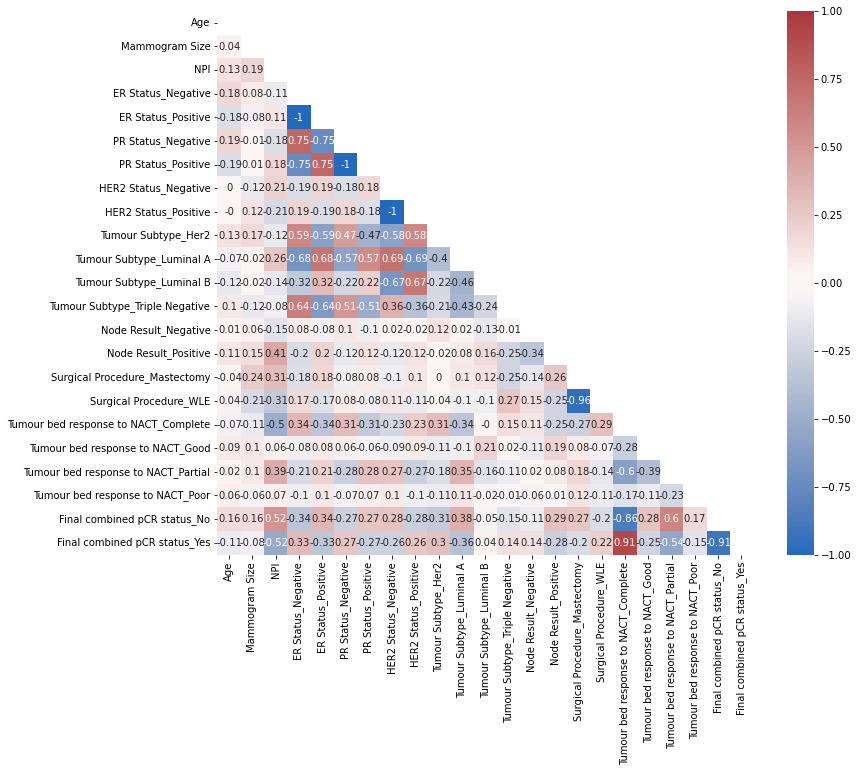

In [25]:
plt.figure(figsize=(12,10))

corr_matrix = df_corr.corr().round(2) # Calculates Correlation Coefficient using Pearson by default 

mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # remove duplicate in the top half of the correlation matrix

sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)

plt.show()

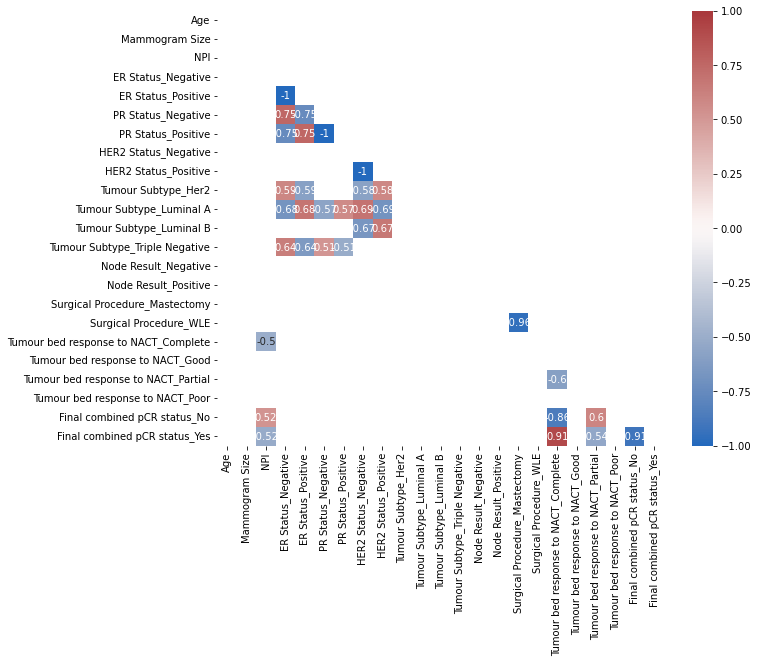

In [26]:
# Lets look at only strong correlatons by filtering our features with correlation score below a filter value

corr_matrix = corr_matrix[abs(corr_matrix) >= 0.5] # strong correlations considered for >= 0.7

plt.figure(figsize=(10,8))

sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, mask = mask, cmap='vlag')

plt.show()

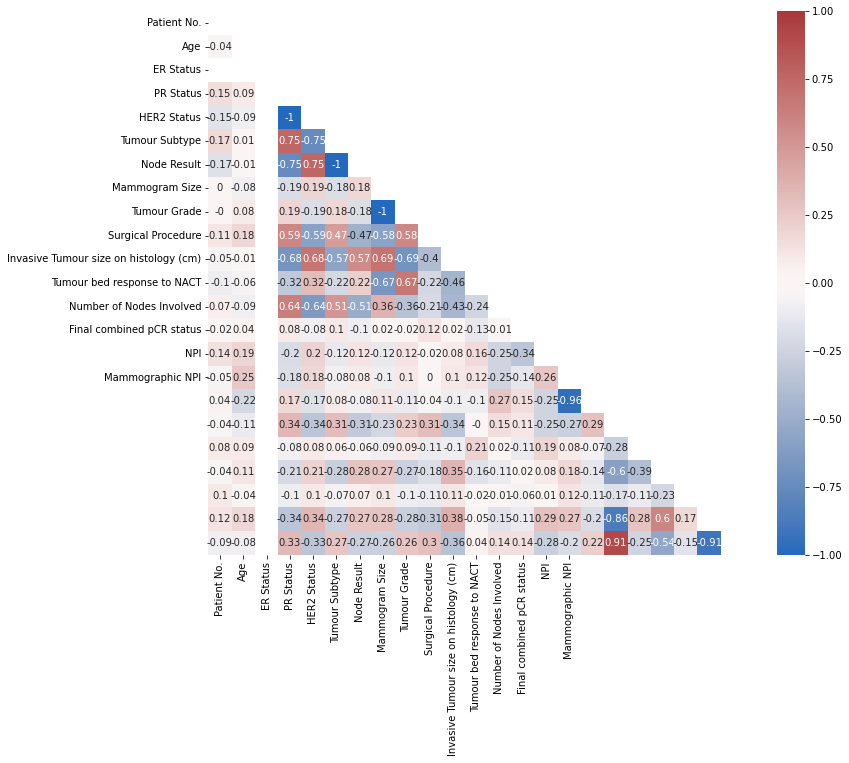

In [27]:
from scipy.stats import spearmanr

plt.figure(figsize=(12,10))

corr_matrix = spearmanr(df_corr).correlation.round(2) # Calculates Correlation Coefficient using Spearman 

mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # remove duplicate in the top half of the correlation matrix

sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, xticklabels=df_clinical.columns,
           yticklabels=df_clinical.columns)

plt.show()

The above correlation matrix identifies correlations between pairs of features using Pearson rather than Spearman because the values are intervals and may/are not ordinal values. Additionally, features from the same original feature that have been one-hot encoded will be highy correlated. What we are looking for here are features that will help determine missing values in one feature that are derived from other features. The above will help with this.

Key correlations:

1. ER Status, PR Status and HER2 Status all appear to correlate with Tumour Subtype. This correlates well with descriptions from section 1.1. For example, Luminal A should correlate positively with ("ER Status_Positive" and/or "PR Status_Positive" AND "HER2 Status_Negative" 

2. ER Status is correlated with Tumour Grade such that a Negative status is positively correlated with Tumour Grade and a Positive status is negatively correlated. Also confirmed from section 1.1.

3. NPI is strongly correlated with "Invasive Tumour Size on Histology (cm)" and "Number of Nodes Involved"

>NPI is the Nottingham Prognostic Index and is used to determine prognosis of patients following breast cancer surgery. The value is calculated using the following pathological criteria

>    - the Size of the tumour
>    - the Number of Nodes involved
>    - the Grade of the Tumour
    
>From above correlation analysis we confirmed correlations between "Invasive Tumour Size on Histology (cm)" and "Number of Nodes Involved". We did not see the correlation with Tumour Grade above but we can use these three features to imput the NPI score and thus reduce missing data from 10.48%.
    
>    The calculation is as follows:
    
>    NPI = (0.2 x Size) + Node Status + Grade [Wikipedia]
    
>    Size is in centimetres
>    Node Status: 0 Nodes = 1, 1 - 3 Nodes = 2, >3 Nodes = 3
>    Grade: Grade I = 1, Grade II = 2, Grade III = 3

4. "Final combined pCR status" is correated strongly with "Tumour bed response to NACT_Complete". It is less strongly correlated with "Tumour bed response to NACT_Partial"

5. **There is a very strong relationship between "Node Result_Positive" and "Node Result_nan". Could this mean that the Nan/missing values are actually Node Result Positive?**

6. "Invasive Tumour size on histology (cm)" and "Number of Nodes Involved": these features have no strong relationships with any other feature so we will impute with median value of columns (features are right skewed)

7. Tumour Grade: as mentioned above, it seems to correlate with ER Status, but from data inspection there may be more. I will ask James about this and possibly inpute the missing 1.6% of data.

## 2. Pre-processing

In [59]:
# Function to calculate NPI

def calculate_NPI(size, num_nodes, grade):
    
    node_status =0 
    
    if num_nodes == 0: node_status=1
    elif num_nodes >=1 and num_nodes <=3: node_status=2
    else: node_status=3
        
    print(size, node_status, grade)
    
    npi = (0.2 * size) + node_status + grade
    
    return npi

In [60]:
# List indexes of rows with missing NPI

idx_npi_nan = df_train.loc[pd.isna(df_train["NPI"]), :].index

for idx in idx_npi_nan:
    size = df_train['Invasive Tumour size on histology (cm)'][idx]
    num_nodes = df_train['Number of Nodes Involved'][idx]
    grade = df_train['Tumour Grade'][idx]
    
    if size == "nan" or num_nodes == "nan" or grade == "nan": print("Skip")
    else:
        npi = calculate_NPI(size, num_nodes, grade)
        df_train.at[idx,'NPI'] = npi

1.5 2 2.0
1.5 1 3.0
0.0 2 2.438775510204082
3.0 1 3.0
1.5 1 3.0
1.5 1 3.0
1.5 1 3.0
1.5 2 2.0
0.0 1 3.0


In [61]:
# Check for missing values after processing

df_train.isna().sum()/df.shape[0]*100

Age                                       0.0
Mammogram Size                            0.0
Tumour Grade                              0.0
Invasive Tumour size on histology (cm)    0.0
Number of Nodes Involved                  0.0
NPI                                       0.0
Sample_1_Let-7a CNRQ                      0.0
Sample_1_Let-7a SE(CNRQ)                  0.0
Sample_1_miR-145 CNRQ                     0.0
Sample_1_miR-145 SE(CNRQ)                 0.0
Sample_1_miR-155 CNRQ                     0.0
Sample_1_miR-155 SE(CNRQ)                 0.0
Sample_1_miR-16 CNRQ                      0.0
Sample_1_miR-16 SE(CNRQ)                  0.0
Sample_1_miR-195 CNRQ                     0.0
Sample_1_miR-195 SE(CNRQ)                 0.0
Sample_1_miR-21 CNRQ                      0.0
Sample_1_miR-21 SE(CNRQ)                  0.0
Sample_1_miR-425 CNRQ                     0.0
Sample_1_miR-425 SE(CNRQ)                 0.0
Sample_2_Let-7a CNRQ                      0.0
Sample_2_Let-7a SE(CNRQ)          

In [62]:
# Export the df dataset (processed)

df_train.to_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_Processed.csv")

In [63]:
df_train = pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_Processed.csv")
df_train.drop('Unnamed: 0', axis=1, inplace=True)

In [64]:
# Drop features that are used to calculate NPI
drop_cols = ['Invasive Tumour size on histology (cm)','Number of Nodes Involved', 'Tumour Grade']
    
df_train = df_train.drop(drop_cols,axis=1)

In [65]:
# Select Features with extreme skewness

# Select features with skewness > 1 or < -1
skew_log = skew_df[(skew_df['Skewness'] > 1) | (skew_df['Skewness'] < -1)]

# Remove columns that have already been removed from the dataset plus the target feature
drop_cols.append('NPI')
skew_log = skew_log[~skew_log['Feature'].isin(list(drop_cols))]

In [66]:
# Apply log transform to features with extreme skewness

#for i in skew_log.index:
#    col_name = skew_df['Feature'][i]
#    skewness = skew_df["Skewness"][i]
    
#    if skewness < 0:
#        min = np.min(df_train[col])
#        df_train[col_name] = np.log(df_train[col_name]+(min*-1+1))
#    else:
#        df_train[col_name] = np.log(df_train[col_name])
    

In [67]:
# Apply MinMaxScaler to X_Train
all_cols = list(df_train.columns)
all_cols.remove('NPI')

minmax=MinMaxScaler(feature_range=(0, 1))
df_train[all_cols]=minmax.fit_transform(df_train[all_cols])


In [68]:
df_train.describe()

Age  Mammogram Size        NPI  Sample_1_Let-7a CNRQ  \
count  99.000000       99.000000  99.000000             99.000000   
mean    0.500588        0.362851   4.603018              0.523828   
std     0.209921        0.203430   1.119139              0.183624   
min     0.000000        0.000000   2.380000              0.000000   
25%     0.357143        0.261111   4.000000              0.432492   
50%     0.500588        0.333333   4.300000              0.523828   
75%     0.642857        0.444444   5.250000              0.631588   
max     1.000000        1.000000   7.400000              1.000000   

       Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
count                 99.000000              99.000000   
mean                   0.196002               0.646340   
std                    0.139411               0.155531   
min                    0.000000               0.000000   
25%                    0.098528               0.573555   
50%                    0.166158               0.680675   
75%                    0.275397               0.737112   
max                    1.000000               1.000000   

       Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
count                  99.000000              99.000000   
mean                    0.233145               0.620352   
std                     0.139266               0.133233   
min                     0.000000               0.000000   
25%                     0.141443               0.603020   
50%                     0.199251               0.648277   
75%                     0.284997               0.678105   
max                     1.000000               1.000000   

       Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
count                  99.000000             99.000000   
mean                    0.237361              0.553511   
std                     0.132863              0.212965   
min                     0.000000              0.000000   
25%                     0.156083              0.442484   
50%                     0.224590              0.553511   
75%                     0.291509              0.690840   
max                     1.000000              1.000000   

       Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
count                 99.000000              99.000000   
mean                   0.163069               0.691635   
std                    0.136622               0.184881   
min                    0.000000               0.000000   
25%                    0.084699               0.629624   
50%                    0.128714               0.717282   
75%                    0.200927               0.819002   
max                    1.000000               1.000000   

       Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
count                  99.000000             99.000000   
mean                    0.171737              0.773951   
std                     0.132524              0.140078   
min                     0.000000              0.000000   
25%                     0.088767              0.753500   
50%                     0.146357              0.789142   
75%                     0.234320              0.848352   
max                     1.000000              1.000000   

       Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  \
count                 99.000000              99.000000   
mean                   0.226312               0.446489   
std                    0.144661               0.212965   
min                    0.000000               0.000000   
25%                    0.129329               0.309160   
50%                    0.203348               0.446489   
75%                    0.287427               0.557516   
max                    1.000000               1.000000   

       Sample_1_miR-425 SE(CNRQ)  Sample_2_Let-7a CNRQ  \
count                  99.000000             99.000000   
mean                    0.099528              0.592712   
std                     0.101626              0.195341   
min         

In [69]:
# Split df_train into dependent and target features

y_train = df_train['NPI']
X_train = df_train.drop('NPI', axis=1).values

### 3. Model Selection & Dimensionality Reduction Pipelines

#### Random Forest Regressor Pipeline

In [70]:
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('regression', RandomForestRegressor())])

In [71]:
N_FEATURES_OPTIONS = [5, 8, 10, 15]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8, 10]
N_ESTIMATORS_OPTIONS = [10, 50, 100]

param_grid = [
    {
        'reduce_dim': [PCA(), KernelPCA(kernel='rbf')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS
    },
    {
        'reduce_dim': [RFE(SVR(kernel='linear', gamma='auto')), RFE(RandomForestRegressor())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS
    },
    {
        'reduce_dim': [RFE(XGBRegressor(booster='gbtree'))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS
    },
    {
        'reduce_dim': [LocallyLinearEmbedding(max_iter = 300)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS
    }
]

In [72]:
# Run the tests
print("Start processing .....", datetime.datetime.now())
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

print("End processing .....", datetime.datetime.now())

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_
RF_features = search.best_estimator_.named_steps["reduce_dim"].support_

Start processing ..... 2022-08-13 18:54:25.632481
Best CV score = 0.180:
Best parameters:  {'reduce_dim': RFE(estimator=XGBRegressor(base_score=None, booster='gbtree',
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, gamma=None, gpu_id=None,
                           importance_type='gain', interaction_constraints=None,
                           learning_rate=None, max_delta_step=None,
                           max_depth=None, min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=None, num_parallel_tree=None,
                           random_state=None, reg_alpha=None, reg_lambda=None,
                           scale_pos_weight=None, subsample=None,
                           tree_method=None, validate_parameters=None,
                           verbosity=None),
    n_features_to_select=10), 'reduce_dim__n_features_to_se

#### KNeighbours Regressor Pipeline

In [76]:
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('regression', KNeighborsRegressor())])

In [77]:
N_FEATURES_OPTIONS = [5, 8, 10, 15]
N_NEIGHBORS = [5, 10, 20, 30]

param_grid = [
    {
        'reduce_dim': [PCA(), KernelPCA(kernel='rbf')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__n_neighbors': N_NEIGHBORS
    },
    {
        'reduce_dim': [RFE(SVR(kernel='linear', gamma='auto')), RFE(RandomForestRegressor())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__n_neighbors': N_NEIGHBORS
    },
    {
        'reduce_dim': [RFE(XGBRegressor(booster='gbtree'))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__n_neighbors': N_NEIGHBORS
    },
    {
        'reduce_dim': [LocallyLinearEmbedding(max_iter = 300)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__n_neighbors': N_NEIGHBORS
    }
]

In [78]:
# Run the tests
print("Start processing .....", datetime.datetime.now())
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

print("End processing .....", datetime.datetime.now())

# store the best params and best model for later use
KN_best_params = search.best_params_
KN_best_model = search.best_estimator_
KN_features = search.best_estimator_.named_steps["reduce_dim"].support_

Start processing ..... 2022-08-13 19:15:36.110104
Best CV score = 0.231:
Best parameters:  {'reduce_dim': RFE(estimator=XGBRegressor(base_score=None, booster='gbtree',
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, gamma=None, gpu_id=None,
                           importance_type='gain', interaction_constraints=None,
                           learning_rate=None, max_delta_step=None,
                           max_depth=None, min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=None, num_parallel_tree=None,
                           random_state=None, reg_alpha=None, reg_lambda=None,
                           scale_pos_weight=None, subsample=None,
                           tree_method=None, validate_parameters=None,
                           verbosity=None),
    n_features_to_select=8), 'reduce_dim__n_features_to_sel

#### Support Vector Machine (SVM) Regression Pipeline

In [79]:
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('regression', SVR(max_iter=5000))])

In [80]:
N_FEATURES_OPTIONS = [5, 8, 10, 15]
C_OPTIONS = [0, 10, 20, 50]
GAMMA_OPTIONS = [1, 0.5, 0.1, 0.01, 0.001]
KERNEL_OPTIONS = ['rbf', 'linear']

param_grid = [
    {
        'reduce_dim': [PCA(), KernelPCA(kernel='rbf')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__C': C_OPTIONS,
        'regression__gamma': GAMMA_OPTIONS,
        'regression__kernel': KERNEL_OPTIONS
    },
    {
        'reduce_dim': [RFE(SVR(kernel='linear', gamma='auto')), RFE(RandomForestRegressor())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__C': C_OPTIONS,
        'regression__gamma': GAMMA_OPTIONS,
        'regression__kernel': KERNEL_OPTIONS
    },
    {
        'reduce_dim': [RFE(XGBRegressor(booster='gbtree'))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__C': C_OPTIONS,
        'regression__gamma': GAMMA_OPTIONS,
        'regression__kernel': KERNEL_OPTIONS
    },
    {
        'reduce_dim': [LocallyLinearEmbedding(max_iter = 300)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__C': C_OPTIONS,
        'regression__gamma': GAMMA_OPTIONS,
        'regression__kernel': KERNEL_OPTIONS
    }
]

In [81]:
print("Start processing .....", datetime.datetime.now())
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

print("End processing .....", datetime.datetime.now())

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_
SVR_features = search.best_estimator_.named_steps["reduce_dim"].support_

Start processing ..... 2022-08-13 19:21:16.370712
Best CV score = 0.229:
Best parameters:  {'reduce_dim': RFE(estimator=XGBRegressor(base_score=None, booster='gbtree',
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, gamma=None, gpu_id=None,
                           importance_type='gain', interaction_constraints=None,
                           learning_rate=None, max_delta_step=None,
                           max_depth=None, min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=None, num_parallel_tree=None,
                           random_state=None, reg_alpha=None, reg_lambda=None,
                           scale_pos_weight=None, subsample=None,
                           tree_method=None, validate_parameters=None,
                           verbosity=None),
    n_features_to_select=5), 'reduce_dim__n_features_to_sel

#### XGBoost Regressor Pipeline

In [82]:
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('regression', XGBRegressor(tree_method='auto', booster='gbtree'))])

In [83]:
N_FEATURES_OPTIONS = [5, 8, 10, 15]
N_ESTIMATORS_OPTIONS = [10, 50, 100]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
GAMMA_OPTIONS = [0.01, 0.1, 1, 5, 10]


param_grid = [
    {
        'reduce_dim': [PCA(), KernelPCA(kernel='rbf')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__gamma': GAMMA_OPTIONS
    },
    {
        'reduce_dim': [RFE(SVR(kernel='linear', gamma='auto')), RFE(RandomForestRegressor())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__gamma': GAMMA_OPTIONS
    },
    {
        'reduce_dim': [RFE(XGBRegressor(booster='gbtree'))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__gamma': GAMMA_OPTIONS
    },
    {
        'reduce_dim': [LocallyLinearEmbedding(max_iter = 300)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__n_estimators': N_ESTIMATORS_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__gamma': GAMMA_OPTIONS
    }
]

In [84]:
print("Start processing .....", datetime.datetime.now())
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

print("End processing .....", datetime.datetime.now())

# store the best params and best model for later use
XGB_best_params = search.best_params_
XGB_best_model = search.best_estimator_
XGB_features = search.best_estimator_.named_steps["reduce_dim"].support_

Start processing ..... 2022-08-13 19:47:51.393731
Best CV score = 0.192:
Best parameters:  {'reduce_dim': RFE(estimator=XGBRegressor(base_score=None, booster='gbtree',
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, gamma=None, gpu_id=None,
                           importance_type='gain', interaction_constraints=None,
                           learning_rate=None, max_delta_step=None,
                           max_depth=None, min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=None, num_parallel_tree=None,
                           random_state=None, reg_alpha=None, reg_lambda=None,
                           scale_pos_weight=None, subsample=None,
                           tree_method=None, validate_parameters=None,
                           verbosity=None),
    n_features_to_select=5), 'reduce_dim__n_features_to_sel

### 4. Model Performance Comparison on Training Data

In [85]:
# model - a trained regression model

def evaluate_model(X, y, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X)
        
    # compute metrics
    _rmse = mean_squared_error(y, _predicted_values, squared=False)
    _mae = mean_absolute_error(y, _predicted_values)
    _r2 = r2_score(y, _predicted_values)
            
    return _rmse, _mae, _r2

In [86]:
RF_rmse, RF_mae, RF_r2 = evaluate_model(X_train, y_train, RF_best_model)
KN_rmse, KN_mae, KN_r2 = evaluate_model(X_train, y_train, KN_best_model)
SVR_rmse, SVR_mae, SVR_r2 = evaluate_model(X_train, y_train, SVR_best_model)
XGB_rmse, XGB_mae, XGB_r2 = evaluate_model(X_train, y_train, XGB_best_model)

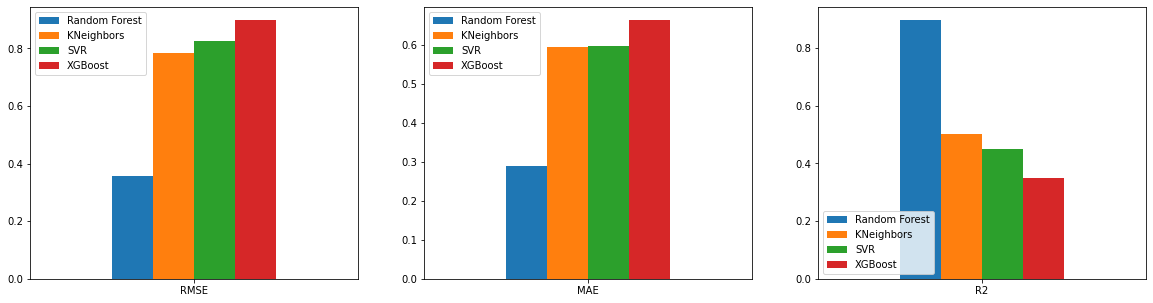

In [87]:
df_rmse = pd.DataFrame({'Random Forest': RF_rmse, 'KNeighbors': KN_rmse, 'SVR': SVR_rmse, 'XGBoost': XGB_rmse}, index=['RMSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'KNeighbors': KN_mae, 'SVR': SVR_mae, 'XGBoost': XGB_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'KNeighbors':KN_r2, 'SVR': SVR_r2, 'XGBoost': XGB_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_rmse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.legend(loc="lower left")
plt.show()

### Feature Importance

In [88]:
names_all = [c for c in df_train if c not in ['NPI']]

print("Table of Features Selected for each Model Tested.")

pd.DataFrame({'Features':names_all,'Random Forest':RF_features, 'KNeighbours': KN_features,
              'SVR':SVR_features,'XGBoost': XGB_features})

Table of Features Selected for each Model Tested.


Features  Random Forest  KNeighbours    SVR  \
0                                    Age          False        False  False   
1                         Mammogram Size          False        False  False   
2                   Sample_1_Let-7a CNRQ          False        False  False   
3               Sample_1_Let-7a SE(CNRQ)          False        False  False   
4                  Sample_1_miR-145 CNRQ          False        False  False   
5              Sample_1_miR-145 SE(CNRQ)          False        False  False   
6                  Sample_1_miR-155 CNRQ          False        False  False   
7              Sample_1_miR-155 SE(CNRQ)          False        False  False   
8                   Sample_1_miR-16 CNRQ          False        False  False   
9               Sample_1_miR-16 SE(CNRQ)          False        False  False   
10                 Sample_1_miR-195 CNRQ          False        False  False   
11             Sample_1_miR-195 SE(CNRQ)          False        False  False   
12                  Sample_1_miR-21 CNRQ          False        False  False   
13              Sample_1_miR-21 SE(CNRQ)          False        False  False   
14                 Sample_1_miR-425 CNRQ          False        False  False   
15             Sample_1_miR-425 SE(CNRQ)          False        False  False   
16                  Sample_2_Let-7a CNRQ          False        False  False   
17              Sample_2_Let-7a SE(CNRQ)          False        False  False   
18                 Sample_2_miR-145 CNRQ          False        False  False   
19             Sample_2_miR-145 SE(CNRQ)          False        False  False   
20                 Sample_2_miR-155 CNRQ          False        False  False   
21             Sample_2_miR-155 SE(CNRQ)          False        False  False   
22                  Sample_2_miR-16 CNRQ          False        False  False   
23              Sample_2_miR-16 SE(CNRQ)          False        False  False   
24                 Sample_2_miR-195 CNRQ          False        False  False   
25             Sample_2_miR-195 SE(CNRQ)          False        False  False   
26                  Sample_2_miR-21 CNRQ          False        False  False   
27              Sample_2_miR-21 SE(CNRQ)          False        False  False   
28                 Sample_2_miR-425 CNRQ          False        False  False   
29             Sample_2_miR-425 SE(CNRQ)           True        False  False   
30                  Sample_3_Let-7a CNRQ          False        False  False   
31              Sample_3_Let-7a SE(CNRQ)          False        False  False   
32                 Sample_3_miR-145 CNRQ          False        False  False   
33             Sample_3_miR-145 SE(CNRQ)           True         True  False   
34                 Sample_3_miR-155 CNRQ          False        False  False   
35             Sample_3_miR-155 SE(CNRQ)          False        False  False   
36                  Sample_3_miR-16 CNRQ          False        False  False   
37              Sample_3_miR-16 SE(CNRQ)          False        False  False   
38                 Sample_3_miR-195 CNRQ          False        False  False   
39             Sample_3_miR-195 SE(CNRQ)          False        False  False   
40                  Sample_3_miR-21 CNRQ          False        False  False   
41              Sample_3_miR-21 SE(CNRQ)          False        False  False   
42                 Sample_3_miR-425 CNRQ          False        False  False   
43             Sample_3_miR-425 SE(CNRQ)          False        False  False   
44                  Sample_4_Let-7a CNRQ          False        False  False   
45              Sample_4_Let-7a SE(CNRQ)          False        False  False   
46                 Sample_4_miR-145 CNRQ          False        False  False   
47             Sample_4_miR-145 SE(CNRQ)          False        False  False   
48                 Sample_4_miR-155 CNRQ          False        False  False   
49             Sample_4_miR-155 SE(CNRQ)          False        False  False   
50 

### 5. Model Performance Comparison on Holdout/Test Dataset

#### Prepare Test Dataset

In [90]:
# Check Test Dataset Statistics

df_test.describe()

Age  Mammogram Size  Tumour Grade  \
count  21.000000       18.000000     24.000000   
mean   55.333333        3.394444      2.541667   
std    13.654059        1.456617      0.508977   
min    25.000000        0.800000      2.000000   
25%    45.000000        2.725000      2.000000   
50%    57.000000        3.300000      3.000000   
75%    67.000000        3.925000      3.000000   
max    75.000000        6.800000      3.000000   

       Invasive Tumour size on histology (cm)  Number of Nodes Involved  \
count                               23.000000                 25.000000   
mean                                 2.294348                  2.120000   
std                                  5.003799                  3.308071   
min                                  0.000000                  0.000000   
25%                                  0.000000                  0.000000   
50%                                  0.900000                  0.000000   
75%                                  2.500000                  4.000000   
max                                 24.000000                 13.000000   

             NPI  Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  \
count  21.000000             23.000000                 23.000000   
mean    4.779524             -0.093605                  0.026132   
std     1.388937              0.913993                  0.009989   
min     3.280000             -3.099901                  0.011205   
25%     4.000000             -0.217154                  0.017571   
50%     4.280000              0.018295                  0.024399   
75%     5.040000              0.445963                  0.034753   
max     9.800000              1.140557                  0.043492   

       Sample_1_miR-145 CNRQ  Sample_1_miR-145 SE(CNRQ)  \
count              23.000000                  23.000000   
mean                0.008064                   0.028547   
std                 0.550904                   0.014389   
min                -1.107189                   0.003589   
25%                -0.348559                   0.017266   
50%                 0.142143                   0.027877   
75%                 0.397172                   0.037999   
max                 1.084896                   0.062031   

       Sample_1_miR-155 CNRQ  Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
count              23.000000                  23.000000             23.000000   
mean               -0.065008                   0.025081              0.043627   
std                 0.667686                   0.011194              0.321374   
min                -1.948633                   0.005657             -0.466712   
25%                -0.388010                   0.016325             -0.197757   
50%                -0.008314                   0.024070              0.026344   
75%                 0.385165                   0.031062              0.247220   
max                 1.252142                   0.046999              0.731800   

       Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
count                 23.000000              22.000000   
mean                   0.023528               0.212112   
std                    0.011291               0.399537   
min                    0.001627              -0.564912   
25%                    0.014250              -0.089976   
50%                    0.024131               0.224264   
75%                    0.030846               0.441317   
max                    0.046131               1.026940   

       Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
count                  22.000000             23.000000   
mean                    0.019959             -0.050594   
std                     0.008045              0.732917   
min                     0.010417             -2.456274   
25%                     0.014018             -0.339070   
50%                     0.017837              0.071001   
75%                     0.024909              0.387601   
max                     

In [91]:
# Impute values in each column for missing values
 
for i in feature_impute_vals.index:
    col_name = feature_impute_vals['Feature'][i]
    col_value = feature_impute_vals["Value"][i]
    df_test[col_name].fillna(col_value, inplace=True)

In [92]:
# One-hot encode the categrical data

ohe_cols = ['ER Status', 'PR Status', 'HER2 Status', 'Tumour Subtype', 'Node Result','Surgical Procedure', 
            'Tumour bed response to NACT', 'Final combined pCR status']

df_test = pd.get_dummies(df_test, columns=ohe_cols, dummy_na=True)

In [93]:
# List indexes of rows with missing NPI

idx_npi_nan = df_test.loc[pd.isna(df_test["NPI"]), :].index

for idx in idx_npi_nan:
    size = df_test['Invasive Tumour size on histology (cm)'][idx]
    num_nodes = df_test['Number of Nodes Involved'][idx]
    grade = df_test['Tumour Grade'][idx]
    
    if size == "nan" or num_nodes == "nan" or grade == "nan": print("Skip")
    else:
        npi = calculate_NPI(size, num_nodes, grade)
        df_test.at[idx,'NPI'] = npi

1.5 1 3.0
1.5 3 2.0
0.9 3 2.438775510204082
0.0 1 3.0


In [94]:
# Calculate the percentage of missing data for each feature

pd.set_option("display.max_rows", None, "display.max_columns", None)
df_test.isna().sum()/df.shape[0]*100

Age                                       0.0
Mammogram Size                            0.0
Tumour Grade                              0.0
Invasive Tumour size on histology (cm)    0.0
Number of Nodes Involved                  0.0
NPI                                       0.0
Sample_1_Let-7a CNRQ                      0.0
Sample_1_Let-7a SE(CNRQ)                  0.0
Sample_1_miR-145 CNRQ                     0.0
Sample_1_miR-145 SE(CNRQ)                 0.0
Sample_1_miR-155 CNRQ                     0.0
Sample_1_miR-155 SE(CNRQ)                 0.0
Sample_1_miR-16 CNRQ                      0.0
Sample_1_miR-16 SE(CNRQ)                  0.0
Sample_1_miR-195 CNRQ                     0.0
Sample_1_miR-195 SE(CNRQ)                 0.0
Sample_1_miR-21 CNRQ                      0.0
Sample_1_miR-21 SE(CNRQ)                  0.0
Sample_1_miR-425 CNRQ                     0.0
Sample_1_miR-425 SE(CNRQ)                 0.0
Sample_2_Let-7a CNRQ                      0.0
Sample_2_Let-7a SE(CNRQ)          

In [95]:
# Drop features that are used to calculate NPI
drop_cols = ['Invasive Tumour size on histology (cm)','Number of Nodes Involved', 'Tumour Grade']
    
df_test = df_test.drop(drop_cols,axis=1)

In [97]:
# Add 'Tumour Subtype_Her2' = 0 as this is missing in test data

df_test['Tumour Subtype_Her2'] = 0

In [98]:
# Apply MinMaxScaler to X_Train
all_cols = list(df_train.columns)
all_cols.remove('NPI')

df_test[all_cols]=minmax.transform(df_test[all_cols])

In [99]:
# Check data statistics again

df_test.describe()

Age  Mammogram Size        NPI  Sample_1_Let-7a CNRQ  \
count  25.000000       25.000000  25.000000             25.000000   
mean    0.506761        0.284889   4.783551              0.519176   
std     0.296784        0.139660   1.297358              0.247734   
min    -0.214286       -0.022222   3.280000             -0.332293   
25%     0.285714        0.200000   4.000000              0.503405   
50%     0.500588        0.300000   4.300000              0.544736   
75%     0.785714        0.333333   5.220000              0.650964   
max     0.976190        0.644444   9.800000              0.868155   

       Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
count                 25.000000              25.000000   
mean                   0.186239               0.645071   
std                    0.103753               0.147942   
min                    0.026317               0.329985   
25%                    0.096162               0.542984   
50%                    0.166158               0.680675   
75%                    0.262341               0.734485   
max                    0.375994               0.943217   

       Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
count                  25.000000              25.000000   
mean                    0.236546               0.636571   
std                     0.139956               0.102023   
min                    -0.012952               0.335113   
25%                     0.125711               0.589081   
50%                     0.224790               0.648277   
75%                     0.318238               0.701594   
max                     0.578866               0.845640   

       Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
count                  25.000000             25.000000   
mean                    0.212019              0.586575   
std                     0.108828              0.236949   
min                     0.013821              0.196793   
25%                     0.126715              0.412691   
50%                     0.203594              0.553511   
75%                     0.251674              0.745103   
max                     0.433350              1.118935   

       Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
count                 25.000000              25.000000   
mean                   0.190383               0.782472   
std                    0.110862               0.121535   
min                   -0.025680               0.543897   
25%                    0.109383               0.702951   
50%                    0.187769               0.770157   
75%                    0.269106               0.857724   
max                    0.424269               1.050866   

       Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
count                  25.000000             25.000000   
mean                    0.122020              0.799808   
std                     0.081287              0.127109   
min                     0.016292              0.365106   
25%                     0.073807              0.775277   
50%                     0.106444              0.808696   
75%                     0.168101              0.873507   
max                     0.346366              1.000013   

       Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  \
count                 25.000000              25.000000   
mean                   0.189434               0.413425   
std                    0.099858               0.236949   
min                    0.031575              -0.118935   
25%                    0.121345               0.254897   
50%                    0.188318               0.446489   
75%                    0.230658               0.587309   
max                    0.413640               0.803207   

       Sample_1_miR-425 SE(CNRQ)  Sample_2_Let-7a CNRQ  \
count                  25.000000             25.000000   
mean                    0.092481              0.627195   
std                     0.055487              0.187294   
min         

In [100]:
# Split df_train into dependent and target features

y_test = df_test['NPI']
X_test = df_test.drop('NPI', axis=1).values

In [101]:
RF_rmse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
KN_rmse, KN_mae, KN_r2 = evaluate_model(X_test, y_test, KN_best_model)
SVR_rmse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)
XGB_rmse, XGB_mae, XGB_r2 = evaluate_model(X_test, y_test, XGB_best_model)

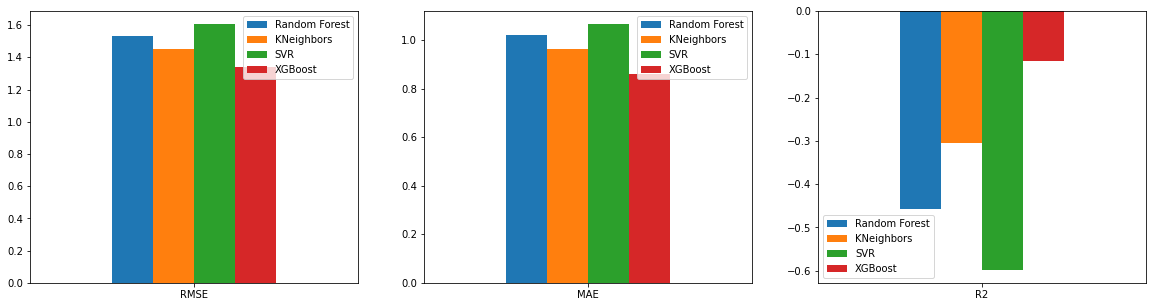

In [103]:
df_rmse = pd.DataFrame({'Random Forest': RF_rmse, 'KNeighbors': KN_rmse, 'SVR': SVR_rmse, 'XGBoost': XGB_rmse}, index=['RMSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'KNeighbors': KN_mae, 'SVR': SVR_mae, 'XGBoost': XGB_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'KNeighbors':KN_r2, 'SVR': SVR_r2, 'XGBoost': XGB_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_rmse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.legend(loc="lower left")
plt.show()

Discussion of these results for regression can be found in Chapter 4, section 4.4.2 of the dissertation